In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')

missing_values = ['n/a', 'na', 'nan', 'N/A', 'NA', 'NaN', 'NAN', '--', 'Missing']
data= pd.read_csv('cleaned_employees.csv', na_values=missing_values, sep=',', decimal='.')

pd.set_option('display.max_columns', None)  # to see all the columns
print(data.head())
print(data.info())

# Print out the column names to check
print(data.columns)

# Check for missing values in the relevant columns
print(data[['Workload', 'Stress', 'SleepHours']].isnull().sum())


   EmpID  Gender  Age MaritalStatus        JobLevel  Experience       Dept  \
0      6    Male   32       Married             Mid           7         IT   
1     11  Female   34       Married             Mid          12    Finance   
2     33  Female   23        Single  Intern/Fresher           1  Marketing   
3     20  Female   29       Married          Junior           6         IT   
4     28   Other   23        Single          Junior           1      Sales   

     EmpType  PhysicalActivityHours  Workload  Stress  SleepHours  \
0  Full-Time                    2.5         2       1         7.6   
1  Full-Time                    1.8         2       2         7.9   
2  Full-Time                    2.1         5       4         6.5   
3   Contract                    1.9         3       1         7.5   
4  Part-Time                    3.7         2       1         4.9   

        CommuteMode  CommuteDistance  TeamSize  NumReports  haveOT  \
0               Car               20        12

In [8]:
# Check data types of the columns
print(data[['Workload', 'Stress', 'SleepHours']].dtypes)


Workload        int64
Stress          int64
SleepHours    float64
dtype: object


Auto-sklearn failed to run: No module named 'autosklearn'
Falling back to RandomizedSearchCV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'poly__include_bias': True, 'poly__degree': np.int64(3), 'linear__fit_intercept': True}
Mean Squared Error of RandomizedSearchCV model: 1.4258356605204852
R^2 Score of RandomizedSearchCV model: 0.10386020034951171
RandomizedSearchCV predictions saved.


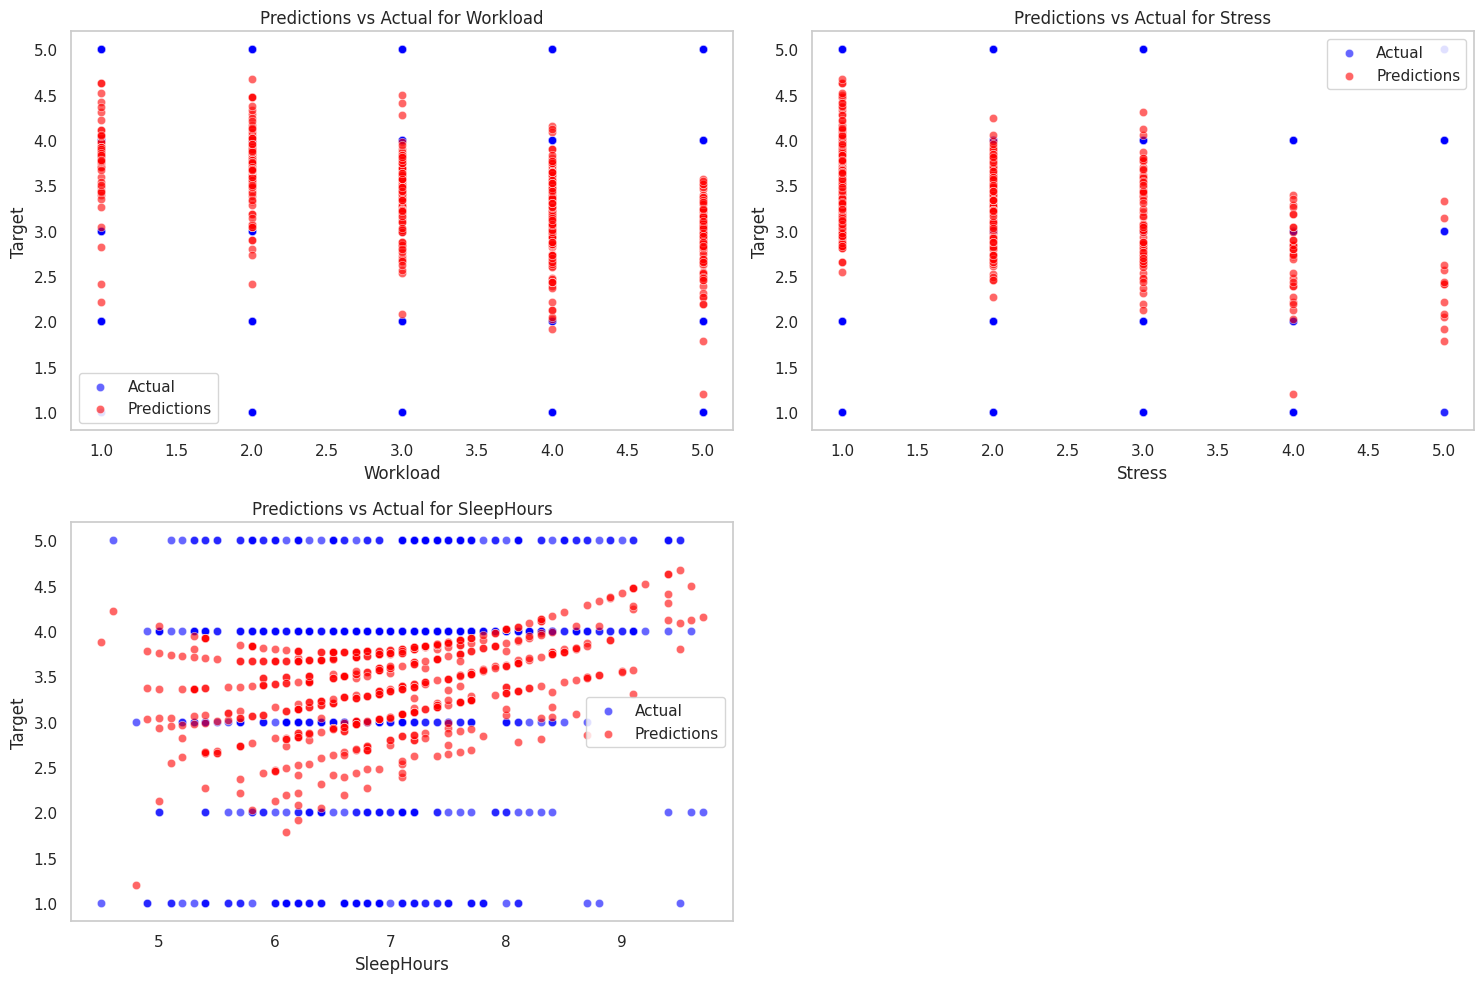

In [14]:
# Necessary imports

# Set seed for reproducibility
np.random.seed(0)

# Assuming the CSV has features and target; modify as per your dataset
X = data[['Workload', 'Stress', 'SleepHours']]  # Replace with your feature columns
y = data['JobSatisfaction']  # Replace with your target column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Try using Auto-sklearn first
try:
    import autosklearn.regression

    # Initialize AutoSklearnRegressor
    automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=120)

    # Fit the Auto-sklearn regressor
    automl.fit(X_train, y_train, dataset_name='polynomial_regression')

    # Make predictions using Auto-sklearn model
    y_pred = automl.predict(X_test)

    # Evaluate the Auto-sklearn model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error of Auto-sklearn model: {mse}')
    print(f'R^2 Score of Auto-sklearn model: {r2}')

    # Show the ensemble models
    ensemble_dict = automl.show_models()
    print("\nEnsemble Models:")
    print(ensemble_dict)

    # Save predictions to a CSV file
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).to_csv('auto_sklearn_predictions.csv', index=False)
    print("Auto-sklearn predictions saved.")

except Exception as e:
    print("Auto-sklearn failed to run:", e)
    print("Falling back to RandomizedSearchCV...")

    # If Auto-sklearn fails, proceed with RandomizedSearchCV
    # Create a pipeline for polynomial regression
    model = Pipeline([
        ('poly', PolynomialFeatures()),  # Polynomial features
        ('linear', LinearRegression())  # Linear regression model
    ])

    # Define the hyperparameters dictionary
    hyperparameters = {
        'poly__degree': np.arange(1, 11),  # Polynomial degrees from 1 to 10
        'linear__fit_intercept': [True, False],  # Fit intercept or not
        'poly__include_bias': [True, False]  # Include bias or not
    }

    # Set up RandomizedSearchCV
    randomsearch = RandomizedSearchCV(model, hyperparameters, cv=5, n_iter=5, n_jobs=-1, random_state=42, verbose=1)

    # Fit the RandomizedSearchCV
    randomsearch.fit(X_train, y_train)

    # Best model and its parameters
    best_model = randomsearch.best_estimator_
    print(f'Best parameters: {randomsearch.best_params_}')

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error of RandomizedSearchCV model: {mse}')
    print(f'R^2 Score of RandomizedSearchCV model: {r2}')

    # Save predictions to a CSV file
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).to_csv('randomized_search_predictions.csv', index=False)
    print("RandomizedSearchCV predictions saved.")

# Set up Seaborn style for visualization
sns.set(style='whitegrid')

# Plot feature vs target value with predictions for each feature
features = X.columns

# Create subplots for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)  # 2x2 subplot
    sns.scatterplot(x=X_test[feature], y=y_test, color='blue', label='Actual', alpha=0.6)
    sns.scatterplot(x=X_test[feature], y=y_pred, color='red', label='Predictions', alpha=0.6)
    plt.title(f'Predictions vs Actual for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for ridge with StandardScaler: {'ridge__alpha': np.float64(0.0001), 'poly__degree': np.int64(2)}
Mean Squared Error of ridge with StandardScaler: 1.4140138510769862
R^2 Score of ridge with StandardScaler: 0.11129022488848006
ridge predictions with StandardScaler saved.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.219e+02, tolerance: 2.979e-01
  model = cd_fast.enet_coordinate_descent(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.189e+03, tolerance: 3.026e-01
  model = cd_fast.enet_coordinate_descent(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

Best parameters for lasso with StandardScaler: {'poly__degree': np.int64(3), 'lasso__alpha': np.float64(0.005994842503189409)}
Mean Squared Error of lasso with StandardScaler: 1.4236654464426766
R^2 Score of lasso with StandardScaler: 0.10522418307398373
lasso predictions with StandardScaler saved.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for ridge with MinMaxScaler: {'ridge__alpha': np.float64(0.0001), 'poly__degree': np.int64(2)}
Mean Squared Error of ridge with MinMaxScaler: 1.4140136076438579
R^2 Score of ridge with MinMaxScaler: 0.1112903778865576
ridge predictions with MinMaxScaler saved.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for lasso with MinMaxScaler: {'poly__degree': np.int64(3), 'lasso__alpha': np.float64(0.005994842503189409)}
Mean Squared Error of lasso with MinMaxScaler: 1.4094415528685764
R^2 Score of lasso with MinMaxScaler: 0.1141639210049954
lasso predictions with MinMaxScaler saved.


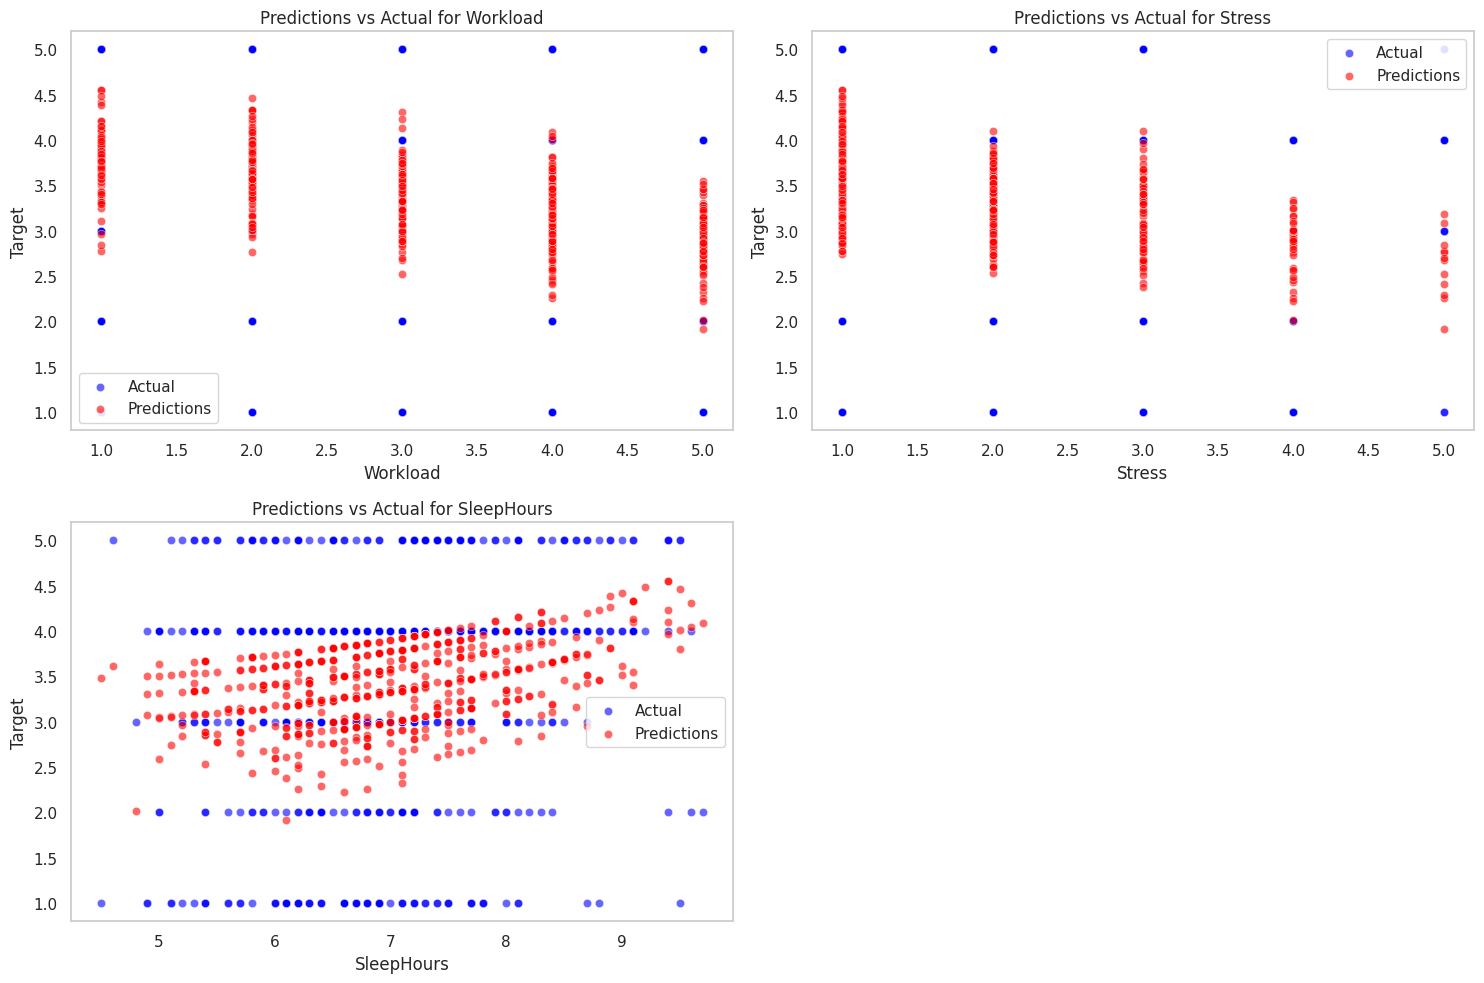

In [11]:
# Ridge and Lasso Regression

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Set seed for reproducibility
np.random.seed(0)

# Assuming the CSV has features and target; modify as per your dataset
X = data[['Workload', 'Stress', 'SleepHours']]  # Replace with your feature columns
y = data['JobSatisfaction']  # Replace with your target column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define scaling options: StandardScaler or MinMaxScaler
scalers = [StandardScaler(), MinMaxScaler()]

# Define Ridge and Lasso models to test
models = {'ridge': Ridge(), 'lasso': Lasso()}

# Define the hyperparameter search space
param_distributions = {
    'poly__degree': np.arange(1, 11),  # Polynomial degrees from 1 to 10
    'ridge__alpha': np.logspace(-4, 4, 10),  # Ridge regularization strength
    'lasso__alpha': np.logspace(-4, 4, 10)   # Lasso regularization strength
}

# Iterate over scalers and models
for scaler in scalers:
    for model_name, model in models.items():
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', scaler),  # Add scaler
            ('poly', PolynomialFeatures()),  # Add polynomial features
            (model_name, model)  # Ridge or Lasso model
        ])

        # Set up RandomizedSearchCV with 5-fold cross-validation
        randomsearch = RandomizedSearchCV(
            pipeline,
            param_distributions={
                'poly__degree': np.arange(1, 11),
                f'{model_name}__alpha': np.logspace(-4, 4, 10)  # Regularization parameter
            },
            cv=5,
            n_iter=10,  # Number of iterations
            n_jobs=-1,
            random_state=42,
            verbose=1
        )

        # Fit the RandomizedSearchCV model
        randomsearch.fit(X_train, y_train)

        # Best model and its parameters
        best_model = randomsearch.best_estimator_
        print(f'Best parameters for {model_name} with {scaler.__class__.__name__}: {randomsearch.best_params_}')

        # Make predictions on the test set
        y_pred = best_model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f'Mean Squared Error of {model_name} with {scaler.__class__.__name__}: {mse}')
        print(f'R^2 Score of {model_name} with {scaler.__class__.__name__}: {r2}')

        # Save predictions to a CSV file
        pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).to_csv(f'{model_name}_{scaler.__class__.__name__}_predictions.csv', index=False)
        print(f"{model_name} predictions with {scaler.__class__.__name__} saved.")

# Set up Seaborn style for visualization
sns.set(style='whitegrid')

# Plot feature vs target value with predictions for each feature
features = X.columns

# Create subplots for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)  # 2x2 subplot
    sns.scatterplot(x=X_test[feature], y=y_test, color='blue', label='Actual', alpha=0.6)
    sns.scatterplot(x=X_test[feature], y=y_pred, color='red', label='Predictions', alpha=0.6)
    plt.title(f'Predictions vs Actual for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


ased on the output you provided, it seems like you're comparing the performance of linear regression, ridge regression, and lasso regression with and without scaling using StandardScaler and MinMaxScaler. The results indicate that lasso regression with MinMaxScaler has the best mean squared error (MSE) and R² score.

Here's a summary of the results:

Linear Regression

Mean Squared Error (MSE): 1.4258
R² Score: 0.1039
Ridge Regression

With StandardScaler:
MSE: 1.4140
R² Score: 0.1113
With MinMaxScaler:
MSE: 1.4140
R² Score: 0.1113
Lasso Regression

With StandardScaler:
MSE: 1.4237
R² Score: 0.1052
With MinMaxScaler:
MSE: 1.4094
R² Score: 0.1142
Conclusion
Lasso Regression with MinMaxScaler seems to perform the best among the tested models, showing the lowest MSE and the highest R² score.
The warnings about convergence indicate that the model may not have fully optimized; consider increasing the number of iterations or adjusting the regularization parameter (alpha) for lasso and ridge regressions.

,degree,include_bias,interaction_only,order
poly,2,True,False,C


,copy_X,fit_intercept,n_jobs,positive
linear,True,True,None,False


Mean Squared Error of linear with StandardScaler: 1.4140138515210696
R^2 Score of linear with StandardScaler: 0.11129022460937299
linear predictions with StandardScaler saved.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for ridge with StandardScaler: {'ridge__alpha': np.float64(0.0001), 'poly__degree': np.int64(2)}


,degree,include_bias,interaction_only,order
poly,2,True,False,C


,alpha,copy_X,fit_intercept,max_iter,positive,random_state,solver,tol
ridge,0.0001,True,True,None,False,None,auto,0.0001


Mean Squared Error of ridge with StandardScaler: 1.4140138510769862
R^2 Score of ridge with StandardScaler: 0.11129022488848006
ridge predictions with StandardScaler saved.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.219e+02, tolerance: 2.979e-01
  model = cd_fast.enet_coordinate_descent(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.192e+03, tolerance: 3.080e-01
  model = cd_fast.enet_coordinate_descent(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

Best parameters for lasso with StandardScaler: {'poly__degree': np.int64(3), 'lasso__alpha': np.float64(0.005994842503189409)}


/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+03, tolerance: 3.103e-01
  model = cd_fast.enet_coordinate_descent(


,degree,include_bias,interaction_only,order
poly,3,True,False,C


,alpha,copy_X,fit_intercept,max_iter,positive,precompute,random_state,selection,tol,warm_start
lasso,0.005995,True,True,1000,False,False,None,cyclic,0.0001,False


Mean Squared Error of lasso with StandardScaler: 1.4236654464426766
R^2 Score of lasso with StandardScaler: 0.10522418307398373
lasso predictions with StandardScaler saved.


,degree,include_bias,interaction_only,order
poly,2,True,False,C


,copy_X,fit_intercept,n_jobs,positive
linear,True,True,None,False


Mean Squared Error of linear with MinMaxScaler: 1.4140138515210696
R^2 Score of linear with MinMaxScaler: 0.1112902246093731
linear predictions with MinMaxScaler saved.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for ridge with MinMaxScaler: {'ridge__alpha': np.float64(0.0001), 'poly__degree': np.int64(2)}


,degree,include_bias,interaction_only,order
poly,2,True,False,C


,alpha,copy_X,fit_intercept,max_iter,positive,random_state,solver,tol
ridge,0.0001,True,True,None,False,None,auto,0.0001


Mean Squared Error of ridge with MinMaxScaler: 1.4140136076438579
R^2 Score of ridge with MinMaxScaler: 0.1112903778865576
ridge predictions with MinMaxScaler saved.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for lasso with MinMaxScaler: {'poly__degree': np.int64(3), 'lasso__alpha': np.float64(0.005994842503189409)}


,degree,include_bias,interaction_only,order
poly,3,True,False,C


,alpha,copy_X,fit_intercept,max_iter,positive,precompute,random_state,selection,tol,warm_start
lasso,0.005995,True,True,1000,False,False,None,cyclic,0.0001,False


Mean Squared Error of lasso with MinMaxScaler: 1.4094415528685764
R^2 Score of lasso with MinMaxScaler: 0.1141639210049954
lasso predictions with MinMaxScaler saved.
    Model          Scaler       MSE       R^2  \
0  linear  StandardScaler  1.414014  0.111290   
1   ridge  StandardScaler  1.414014  0.111290   
2   lasso  StandardScaler  1.423665  0.105224   
3  linear    MinMaxScaler  1.414014  0.111290   
4   ridge    MinMaxScaler  1.414014  0.111290   
5   lasso    MinMaxScaler  1.409442  0.114164   

                                     Best Parameters  
0                                                N/A  
1        {'ridge__alpha': 0.0001, 'poly__degree': 2}  
2  {'poly__degree': 3, 'lasso__alpha': 0.00599484...  
3                                                N/A  
4        {'ridge__alpha': 0.0001, 'poly__degree': 2}  
5  {'poly__degree': 3, 'lasso__alpha': 0.00599484...  


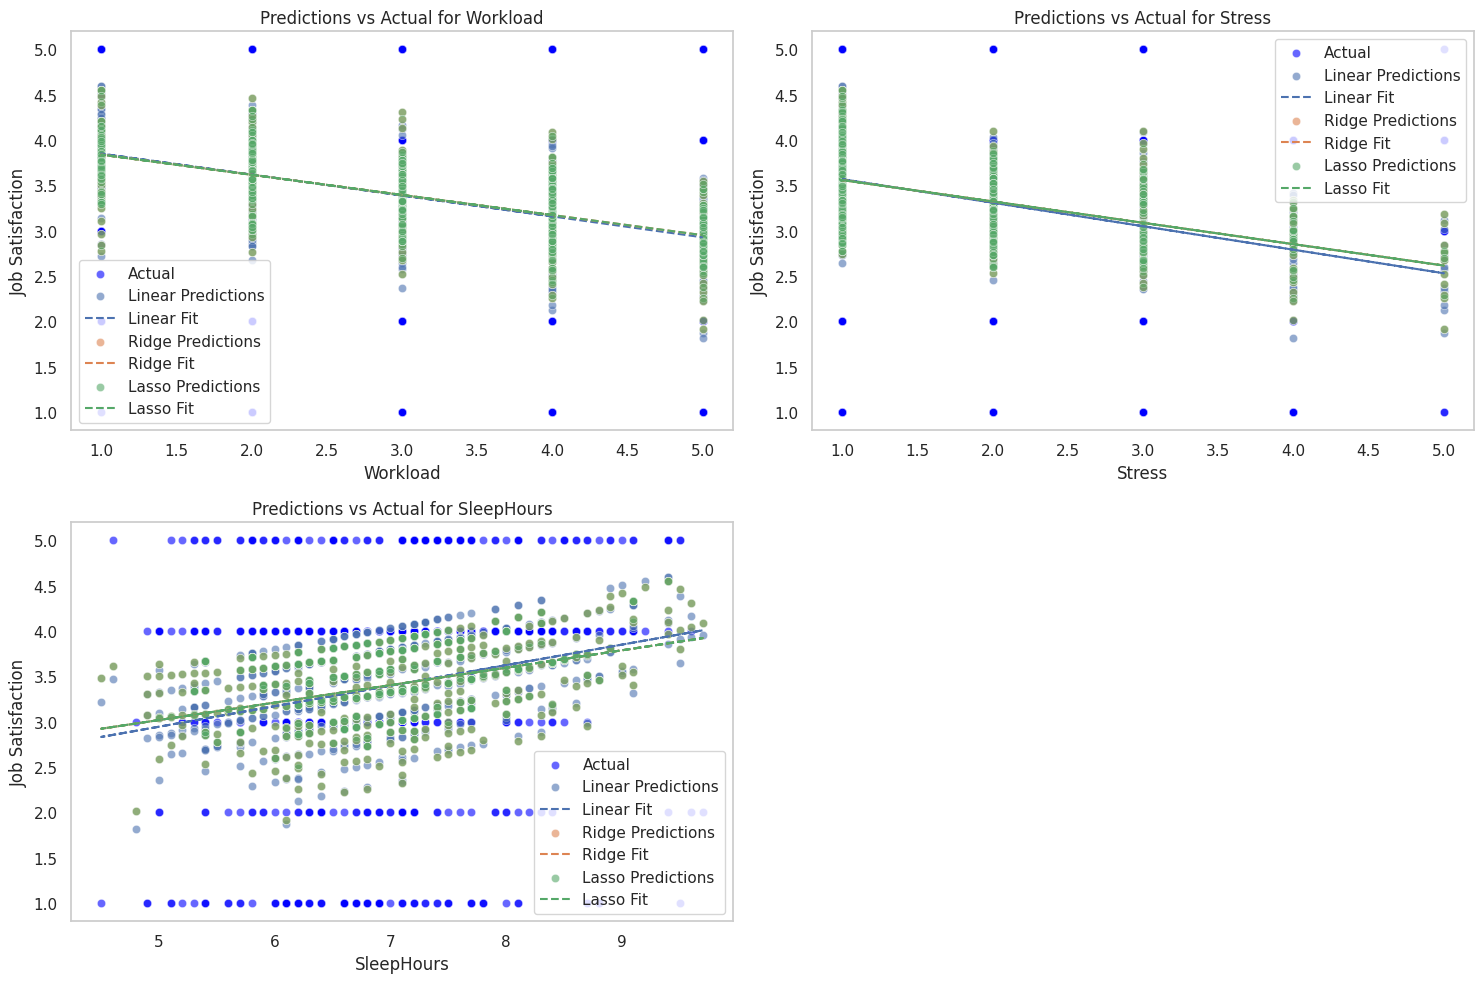

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from IPython.display import display

# Set seed for reproducibility
np.random.seed(0)

# Load your dataset here
 # Replace with your actual dataset path
X = data[['Workload', 'Stress', 'SleepHours']]  # Replace with your feature columns
y = data['JobSatisfaction']  # Replace with your target column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define scaling options: StandardScaler or MinMaxScaler
scalers = [StandardScaler(), MinMaxScaler()]

# Define models to test
models = {
    'linear': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso()
}

# Define the hyperparameter search space
param_distributions = {
    'poly__degree': np.arange(1, 11),  # Polynomial degrees from 1 to 10
    'ridge__alpha': np.logspace(-4, 4, 10),  # Ridge regularization strength
    'lasso__alpha': np.logspace(-4, 4, 10)   # Lasso regularization strength
}

# Create a DataFrame to collect results
results = []

# Iterate over scalers and models
for scaler in scalers:
    for model_name, model in models.items():
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', scaler),  # Add scaler
            ('poly', PolynomialFeatures(include_bias=True)),  # Add polynomial features
            (model_name, model)  # Linear, Ridge, or Lasso model
        ])

        # Set up RandomizedSearchCV with 5-fold cross-validation for non-linear models
        if model_name in ['ridge', 'lasso']:
            randomsearch = RandomizedSearchCV(
                pipeline,
                param_distributions={
                    'poly__degree': np.arange(1, 11),
                    f'{model_name}__alpha': np.logspace(-4, 4, 10)  # Regularization parameter
                },
                cv=5,
                n_iter=10,  # Number of iterations
                n_jobs=-1,
                random_state=42,
                verbose=1
            )

            # Fit the RandomizedSearchCV model
            randomsearch.fit(X_train, y_train)

            # Best model and its parameters
            best_model = randomsearch.best_estimator_
            print(f'Best parameters for {model_name} with {scaler.__class__.__name__}: {randomsearch.best_params_}')
            
            # Display model parameters
            display(pd.DataFrame(best_model['poly'].get_params(), index=['poly']))
            display(pd.DataFrame(best_model[model_name].get_params(), index=[model_name]))
            
            # Make predictions on the test set
            y_pred = best_model.predict(X_test)

        else:  # For linear regression, no random search
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            best_model = pipeline  # Use the fitted pipeline as the best model
            
            # Display model parameters
            display(pd.DataFrame(best_model['poly'].get_params(), index=['poly']))
            display(pd.DataFrame(best_model[model_name].get_params(), index=[model_name]))

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f'Mean Squared Error of {model_name} with {scaler.__class__.__name__}: {mse}')
        print(f'R^2 Score of {model_name} with {scaler.__class__.__name__}: {r2}')

        # Save results to the DataFrame
        results.append({
            'Model': model_name,
            'Scaler': scaler.__class__.__name__,
            'MSE': mse,
            'R^2': r2,
            'Best Parameters': randomsearch.best_params_ if model_name in ['ridge', 'lasso'] else 'N/A'
        })

        # Save predictions to a CSV file
        pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).to_csv(f'{model_name}_{scaler.__class__.__name__}_predictions.csv', index=False)
        print(f"{model_name} predictions with {scaler.__class__.__name__} saved.")

# Convert results to DataFrame for summary
results_df = pd.DataFrame(results)
print(results_df)

# Plot feature vs target value with predictions for each model
sns.set(style='whitegrid')

# Create subplots for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(X.columns):
    plt.subplot(2, 2, i + 1)  # 2x2 subplot
    sns.scatterplot(x=X_test[feature], y=y_test, color='blue', label='Actual', alpha=0.6)
    
    # Plot for each model
    for model_name in models.keys():
        if model_name == 'linear':
            y_pred = LinearRegression().fit(X_train, y_train).predict(X_test)
        else:
            # Use the best model for ridge and lasso
            y_pred = randomsearch.predict(X_test) if model_name in ['ridge', 'lasso'] else best_model.predict(X_test)
        
        sns.scatterplot(x=X_test[feature], y=y_pred, label=f'{model_name.capitalize()} Predictions', alpha=0.6)
    
        # Fit a linear regression line
        linear_fit = np.polyfit(X_test[feature], y_pred, 1)
        plt.plot(X_test[feature], linear_fit[0] * X_test[feature] + linear_fit[1], label=f'{model_name.capitalize()} Fit', linestyle='--')

    plt.title(f'Predictions vs Actual for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Job Satisfaction')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Load your dataset
 # Replace with your dataset path

# Set seed for reproducibility
np.random.seed(0)

# Assuming the dataset has the features and target defined
X = data[['Workload', 'Stress', 'SleepHours']]  # Replace with your feature columns
y = data['JobSatisfaction']  # Replace with your target column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define scalers and models
scalers = [StandardScaler(), MinMaxScaler()]
models = {
    'linear': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso()
}

# Initialize a DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Scaler', 'MSE', 'R^2'])

# Define hyperparameter grids
param_grid = {
    'poly__degree': np.arange(1, 11),  # Polynomial degrees from 1 to 10
}

# Hyperparameter search space for Ridge and Lasso
param_distributions = {
    'ridge__alpha': np.logspace(-4, 4, 20),  # Ridge regularization strength with more intervals
    'lasso__alpha': np.logspace(-4, 4, 20)   # Lasso regularization strength with more intervals
}

# Iterate over scalers and models
for scaler in scalers:
    for model_name, model in models.items():
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', scaler),
            ('poly', PolynomialFeatures(include_bias=False)),  # Add polynomial features
            (model_name, model)  # Add model
        ])

        # Set up RandomizedSearchCV and GridSearchCV based on model type
        if model_name in ['ridge', 'lasso']:
            search = RandomizedSearchCV(  # Use RandomizedSearchCV
                pipeline,
                param_distributions={
                    'poly__degree': np.arange(1, 11),
                    f'{model_name}__alpha': np.logspace(-4, 4, 20)
                },
                cv=5,
                n_iter=30,  # Increase the number of iterations for better exploration
                n_jobs=-1,
                random_state=42,
                verbose=1
            )
        else:
            search = GridSearchCV(  # Use GridSearchCV for Linear Regression
                pipeline,
                param_grid=param_grid,
                cv=5,
                n_jobs=-1,
                verbose=1
            )

        # Fit the search model
        search.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = search.best_estimator_.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results = results.append({'Model': model_name, 'Scaler': scaler.__class__.__name__, 'MSE': mse, 'R^2': r2}, ignore_index=True)

# Display the results DataFrame
pd.set_option('display.max_rows', None)
print(results)

# Visualization
plt.figure(figsize=(15, 10))
for model_name in models.keys():
    for scaler in scalers:
        subset = results[(results['Model'] == model_name) & (results['Scaler'] == scaler.__class__.__name__)]
        if not subset.empty:
            # Make predictions using the best estimator for plotting
            best_estimator = search.best_estimator_
            y_pred_plot = best_estimator.predict(X_test)
            
            # Scatter plot of actual vs predicted
            plt.scatter(y_test, y_pred_plot, alpha=0.6, label=f'{model_name} with {scaler.__class__.__name__}')
            # Regression line
            plt.plot(y_test, y_test, color='red', linewidth=2)

plt.title('Actual vs Predicted Job Satisfaction')
plt.xlabel('Actual Job Satisfaction')
plt.ylabel('Predicted Job Satisfaction')
plt.legend()
plt.grid()
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits


AttributeError: 'DataFrame' object has no attribute 'append'

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.116e+03, tolerance: 2.979e-01
  model = cd_fast.enet_coordinate_descent(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e+03, tolerance: 3.103e-01
  model = cd_fast.enet_coordinate_descent(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.797e-01, tolerance: 2.979e-01
  model = cd_fast.enet_coordinate_descent(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.507e-01, tolerance: 3.029e-01
  model = cd_fast.enet_coordinate_descent(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

    Model          Scaler       MSE       R^2
0  linear  StandardScaler  1.414014  0.111290
1   ridge  StandardScaler  1.414007  0.111295
2   lasso  StandardScaler  1.403909  0.117641
3  linear    MinMaxScaler  1.414014  0.111290
4   ridge    MinMaxScaler  1.411999  0.112557
5   lasso    MinMaxScaler  1.408992  0.114446


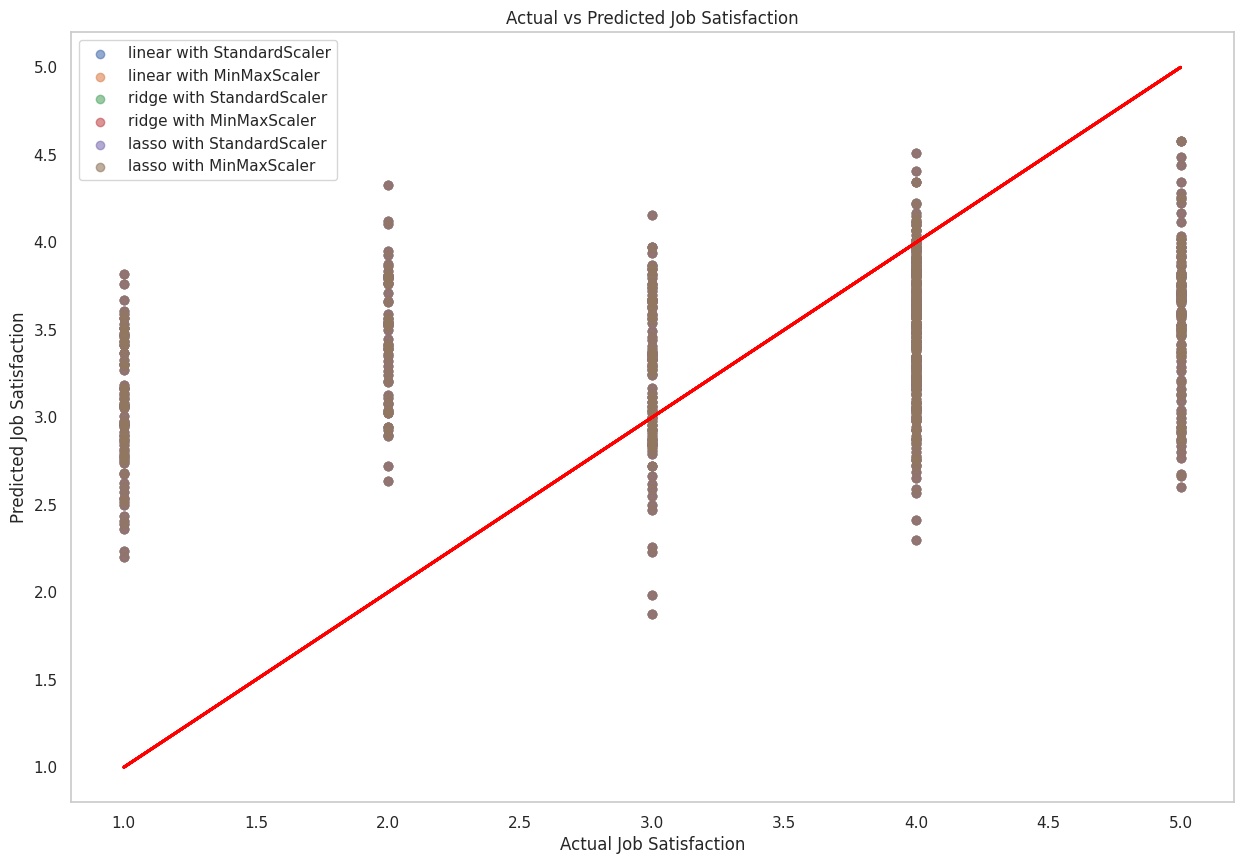

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Load your dataset

# Set seed for reproducibility
np.random.seed(0)

# Assuming the dataset has the features and target defined
X = data[['Workload', 'Stress', 'SleepHours']]  # Replace with your feature columns
y = data['JobSatisfaction']  # Replace with your target column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define scalers and models
scalers = [StandardScaler(), MinMaxScaler()]
models = {
    'linear': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso()
}

# Initialize a list to store results
results_list = []

# Define hyperparameter grids
param_grid = {
    'poly__degree': np.arange(1, 11),  # Polynomial degrees from 1 to 10
}

# Hyperparameter search space for Ridge and Lasso
param_distributions = {
    'ridge__alpha': np.logspace(-4, 4, 20),  # Ridge regularization strength with more intervals
    'lasso__alpha': np.logspace(-4, 4, 20)   # Lasso regularization strength with more intervals
}

# Iterate over scalers and models
for scaler in scalers:
    for model_name, model in models.items():
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', scaler),
            ('poly', PolynomialFeatures(include_bias=False)),  # Add polynomial features
            (model_name, model)  # Add model
        ])

        # Set up RandomizedSearchCV and GridSearchCV based on model type
        if model_name in ['ridge', 'lasso']:
            search = RandomizedSearchCV(  # Use RandomizedSearchCV
                pipeline,
                param_distributions={
                    'poly__degree': np.arange(1, 11),
                    f'{model_name}__alpha': np.logspace(-4, 4, 20)
                },
                cv=5,
                n_iter=30,  # Increase the number of iterations for better exploration
                n_jobs=-1,
                random_state=42,
                verbose=1
            )
        else:
            search = GridSearchCV(  # Use GridSearchCV for Linear Regression
                pipeline,
                param_grid=param_grid,
                cv=5,
                n_jobs=-1,
                verbose=1
            )

        # Fit the search model
        search.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = search.best_estimator_.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results in a dictionary and add to the results list
        results_list.append({'Model': model_name, 'Scaler': scaler.__class__.__name__, 'MSE': mse, 'R^2': r2})

# Create a DataFrame from the results list
results = pd.DataFrame(results_list)

# Display the results DataFrame
pd.set_option('display.max_rows', None)
print(results)

# Visualization
plt.figure(figsize=(15, 10))
for model_name in models.keys():
    for scaler in scalers:
        subset = results[(results['Model'] == model_name) & (results['Scaler'] == scaler.__class__.__name__)]
        if not subset.empty:
            # Make predictions using the best estimator for plotting
            best_estimator = search.best_estimator_
            y_pred_plot = best_estimator.predict(X_test)
            
            # Scatter plot of actual vs predicted
            plt.scatter(y_test, y_pred_plot, alpha=0.6, label=f'{model_name} with {scaler.__class__.__name__}')
            # Regression line
            plt.plot(y_test, y_test, color='red', linewidth=2)

plt.title('Actual vs Predicted Job Satisfaction')
plt.xlabel('Actual Job Satisfaction')
plt.ylabel('Predicted Job Satisfaction')
plt.legend()
plt.grid()
plt.show()
